In [4]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [5]:
#load the model
from tensorflow.keras.models import load_model
model = load_model("emotion_model.h5.hdf5", compile=False)

In [6]:
# Load grayscale image
img = cv2.imread("test_face.png", cv2.IMREAD_GRAYSCALE)

# Resize to (64, 64) to match model input
img_resized = cv2.resize(img, (64, 64))

# Normalize and expand dimensions
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=-1)  # Shape: (64, 64, 1)
img_array = np.expand_dims(img_array, axis=0)   # Shape: (1, 64, 64, 1)

In [7]:
#Create grad model using the last conv layer
grad_model = tf.keras.models.Model(
    [model.inputs], 
    [model.get_layer("conv2d_7").output, model.output]
                    )

In [8]:
#get gradient and activation
import tensorflow as tf

def get_gradients_and_activations(model, last_conv_layer_name, img_tensor):
    """
    Returns gradients and activations from a given convolutional layer.

    Args:
        model: A tf.keras.Model instance.
        last_conv_layer_name: String name of the convolutional layer to target.
        img_tensor: Preprocessed image tensor of shape (1, H, W, C).

    Returns:
        conv_output: Activation of the target conv layer.
        grads: Gradient of target class output w.r.t. conv layer output.
        pred_index: Predicted class index.
        predictions: Model output probabilities/logits.
    """

    # Build a model with outputs at the last conv layer and final prediction
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    # Record gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients of the class output with respect to conv layer
    grads = tape.gradient(class_output, conv_outputs)

    return conv_outputs[0], grads[0], pred_index.numpy(), predictions[0].numpy()


In [9]:
last_conv_layer_name = "conv2d_7"  # Your last conv layer

# Get the gradients and activation
conv_output, grads, pred_index, prediction = get_gradients_and_activations(
    model, last_conv_layer_name, img_array
)

# Build the heatmap
heatmap = tf.reduce_mean(grads, axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

C:\Users\agnih\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_1']
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


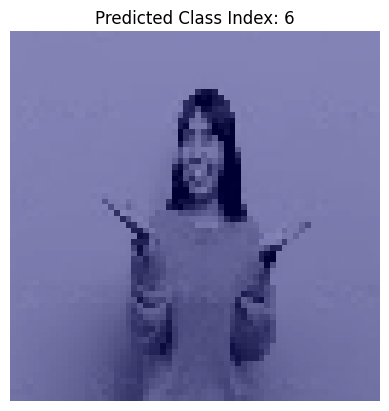

In [10]:

# Ensure original image is in BGR (3 channels) to match heatmap
img_color = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)

# Resize heatmap to match the original image if needed
heatmap_resized = cv2.resize(heatmap, (img_color.shape[1], img_color.shape[0]))

# Blend heatmap with the original image
overlay_img = cv2.addWeighted(img_color, 0.6, heatmap_resized, 0.4, 0)
# Show the result
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted Class Index: {pred_index}")
plt.show()

In [11]:
# Resize the heatmap to match original image size
import cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert heatmap to 0–255 and apply color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Ensure original image is in 0–255 uint8 format
if img.max() <= 1.0:
    img = np.uint8(255 * img)
else:
    img = np.uint8(img)

# Create superimposed image
superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
cv2.imwrite("gradcam_output.png",superimposed_img)

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:665: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'
